# Statistically approved audience signals comparasion

On the Internet, you can find many marketing cases claiming that males convert **50%** better than females, leading to decisions to create separate campaigns for this audience and reallocate more budget accordingly. Or, you might see statements like: our best-performing age group is **35-44** years old, while the worst is **55+**, so we decided to turn off the latter due to budget limitations.

I have always wondered how to include both ***clicks and conversions*** in my analysis since I need to consider both lead quantity and cost efficiency.

Let me show you charts I'm pretty sure you have in your Looker Studios, Power BIs or other graphical tools.

We first need to read the input file. It should include the following Dimensions: Device, Gender, Age, Clicks, Conversions. Ideally, you should use GA4 to import unique users and unique conversions (we only care if somebody left a contact or bought something once).

Import required libraries

In [171]:
import pandas
import numpy
import scipy.stats
import seaborn
import matplotlib.pyplot as plt
import itertools
from IPython.display import display

Turn off Pandas display limitations

In [172]:
# Show all columns without wrapping
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

# Optional: prevent long text truncation
pd.set_option('display.max_colwidth', None)

Read the input

In [173]:
df = pd.read_csv('input.csv')
df = df[df['Lead']>0] #we don't need data about dimensions without conversions
df['Converted_no'] = df['Clicks']-df['Lead']
df = df.rename(columns={'Lead':'Converted_yes'})

Form proper datasets

In [165]:
df_device = df[['Device','Converted_yes','Converted_no']].groupby('Device').sum().reset_index()
df_device['Device_Gender_Age'] = df_device['Device']
df_device['CR'] = df_device['Converted_yes']/(df_device['Converted_yes']+df_device['Converted_no'])
df_gender = df[['Gender','Converted_yes','Converted_no']].groupby('Gender').sum().reset_index()
df_gender['Device_Gender_Age'] = df_gender['Gender']
df_gender['CR'] = df_gender['Converted_yes']/(df_gender['Converted_yes']+df_gender['Converted_no'])
df_age = df[['Age','Converted_yes','Converted_no']].groupby('Age').sum().reset_index()
df_age['Device_Gender_Age'] = df_age['Age']
df_age['CR'] = df_age['Converted_yes']/(df_age['Converted_yes']+df_age['Converted_no'])

And here are our charts

## Pies

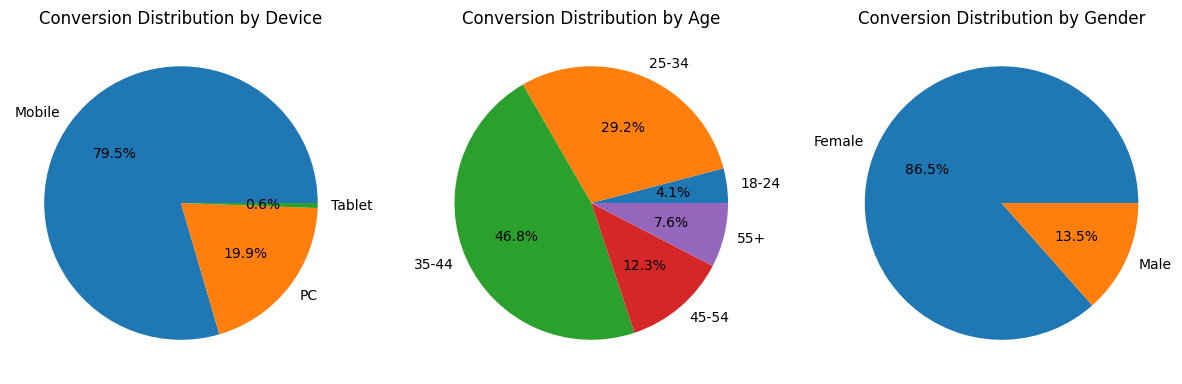

In [184]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5)) 


axs[0].pie(df_device['Converted_yes'], labels=df_device['Device'], autopct='%1.1f%%')
axs[0].set_title('Conversion Distribution by Device')

axs[1].pie(df_age['Converted_yes'], labels=df_age['Age'], autopct='%1.1f%%')
axs[1].set_title('Conversion Distribution by Age')

axs[2].pie(df_gender['Converted_yes'], labels=df_gender['Gender'], autopct='%1.1f%%')
axs[2].set_title('Conversion Distribution by Gender')

plt.show()

## Bars

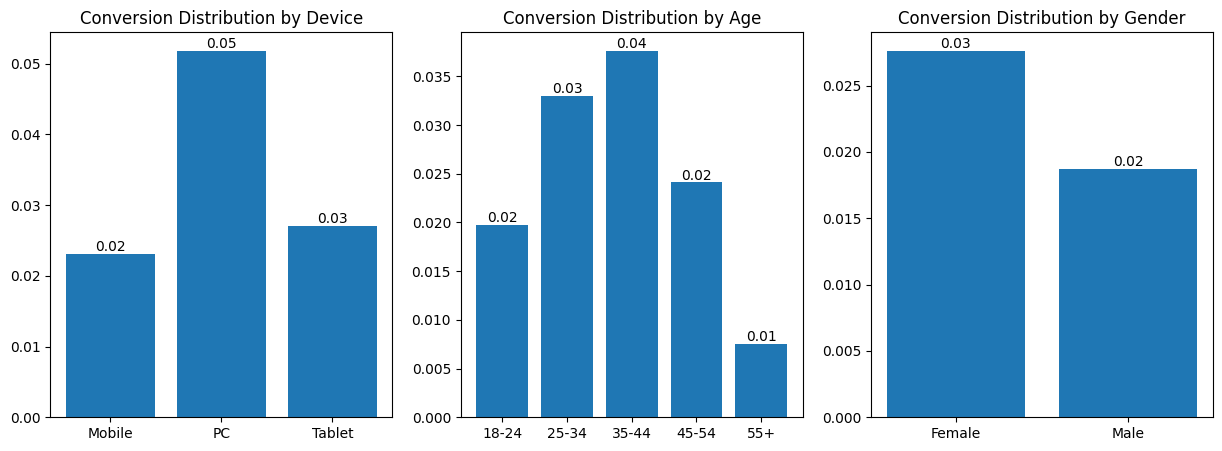

In [191]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  


bars = axs[0].bar(df_device['Device'], df_device['CR'])
axs[0].set_title('Conversion Distribution by Device')
for bar in bars:
    height = bar.get_height()
    axs[0].text(bar.get_x() + bar.get_width() / 2, 
                height,                           
                f'{height:.2f}',                   
                ha='center',                      
                va='bottom')         


bars = axs[1].bar(df_age['Age'], df_age['CR'])
axs[1].set_title('Conversion Distribution by Age')
for bar in bars:
    height = bar.get_height()
    axs[1].text(bar.get_x() + bar.get_width() / 2, 
                height,                           
                f'{height:.2f}',                   
                ha='center',                      
                va='bottom')         

bars = axs[2].bar(df_gender['Gender'], df_gender['CR'])
axs[2].set_title('Conversion Distribution by Gender')
for bar in bars:
    height = bar.get_height()
    axs[2].text(bar.get_x() + bar.get_width() / 2, 
                height,                           
                f'{height:.2f}',                   
                ha='center',                      
                va='bottom')         

plt.show()

You can see many insights already. Your main source of leads is **Females**, your best-performing Age is **35-44**, and **Tablets convert better than Mobiles**. 

But are you sure it didn't happen occasionally, and that you can be confident these results will remain stable in the future?

Nowadays, it is obvious to us that smoking causes lung cancer. However, this was not clear a few decades ago. You can find pictures of the Tour de France where cyclists are smoking cigarettes. At that time, with the help of cigarette companies, everyone was convinced that tobacco was not only harmless but even good for your health.

Also, you may have heard about the "Left-Brain vs. Right-Brain" myth. Many people were convinced that men are “left-brained” (logical) and women “right-brained” (creative), but larger, more rigorous analyses have found no statistically significant difference in hemispheric dominance by gender.

And there is something marketers avoid as far as low-budget projects - a statistically approved approach. With it you can easily define *Tablets* and *55+* are outliers, and there is no difference in conversion rate for *Females and Males* in our dataset.

I'm not going to explain the chi-square test, and you can find more information about it in the "Data Analysis Tools" course by Wesleyan University:
https://www.coursera.org/learn/data-analysis-tools?specialization=data-analysis

All you need to know a p-value in a chi-square test shows how likely it is that the differences you see between groups happened just by chance.

A small p-value (usually below 0.05) means the difference is probably real, not random.

A large p-value means the difference could just be due to luck, so no strong evidence for a real effect.

It's a way to check if your results are meaningful or just coincidence.

## Code

Define the Bonferroni Test function

In [166]:
def bonferroni_test(df):

    ct1 = pd.DataFrame({
    1: df.set_index('Device_Gender_Age')['Converted_yes'],
    0: df.set_index('Device_Gender_Age')['Converted_no']
}).T
    
    # column percentages
    colsum=ct1.sum(axis=0)
    colpct=ct1/colsum
    
    # chi-square
    cs1= scipy.stats.chi2_contingency(ct1)
    print (f'P-value for all dimensions is {cs1.pvalue}')
    
    # All combinations of 2 column names
    col_combos = list(itertools.combinations(ct1.columns, 2))
    
    groupa_list = []
    groupb_list = []
    pvalue_list = []
    bonferroni_correction = 0.05/len(col_combos)
    print(f'Bonferroni Correction is {bonferroni_correction}')
    
    for i in col_combos:
        cti = ct1[list(i)]
        groupa_list.append(cti.columns[0])
        groupb_list.append(cti.columns[1])
    
        csi= scipy.stats.chi2_contingency(cti)
        pvalue_list.append(csi.pvalue)
    
    
    df_result = pd.DataFrame({'Group_A':groupa_list,'Group_B':groupb_list,'pvalue':pvalue_list})
    df_result['Bonferroni_Correction'] = df_result['pvalue']<bonferroni_correction
    
    
    
    df_result = df_result.merge(df[['Device_Gender_Age','Converted_yes','Converted_no']],left_on='Group_A',right_on='Device_Gender_Age')

    df_result['Group_A_CR'] = df_result['Converted_yes']/(df_result['Converted_yes']+df_result['Converted_no'])
    df_result = df_result.drop(columns = ['Device_Gender_Age','Converted_yes','Converted_no'])
    
    df_result = df_result.merge(df[['Device_Gender_Age','Converted_yes','Converted_no']],left_on='Group_B',right_on='Device_Gender_Age')
    
    df_result['Group_B_CR'] = df_result['Converted_yes']/(df_result['Converted_yes']+df_result['Converted_no'])
    df_result = df_result.drop(columns = ['Device_Gender_Age','Converted_yes','Converted_no'])

    if df_result.shape[0] >10:
        print('\nThese groups has a statistical difference:\n')
        df_result = df_result[df_result['Bonferroni_Correction']==1][['Group_A','Group_B','Group_A_CR','Group_B_CR','pvalue']]
    else:
        df_result = df_result[['Group_A','Group_B','Group_A_CR','Group_B_CR','pvalue','Bonferroni_Correction']]
        print('\nHere is the result of Bonferroni Post Hoc Tests:\n')
    
    
    mask = df_result['Group_A_CR'] < df_result['Group_B_CR']
    df_result.loc[mask, ['Group_A', 'Group_B']] = df_result.loc[mask, ['Group_B', 'Group_A']].values
    df_result.loc[mask, ['Group_A_CR', 'Group_B_CR']] = df_result.loc[mask, ['Group_B_CR', 'Group_A_CR']].values
    
    
    df_result = df_result.sort_values(by='Group_A_CR', ascending=False).reset_index(drop=True)
    
    
    display(df_result)


## Devices

In [167]:
print(df_device[['Device','Converted_yes','Converted_no','CR']],'\n')
bonferroni_test(df_device)

   Device  Converted_yes  Converted_no        CR
0  Mobile            136          5756  0.023082
1      PC             34           622  0.051829
2  Tablet              1            36  0.027027 

P-value for all dimensions is 6.48375795369339e-05
Bonferroni Correction is 0.016666666666666666

Here is the result of Bonferroni Post Hoc Tests:



,Group_A,Group_B,Group_A_CR,Group_B_CR,pvalue,Bonferroni_Correction
0,PC,Mobile,0.051829,0.023082,0.00002,True
1,PC,Tablet,0.051829,0.027027,0.77604,False
2,Tablet,Mobile,0.027027,0.023082,1.00000,False


### Interpretation

So, what do we see here? While the conversion rate comparison shows that tablets convert better than mobiles, the chi-square test indicates that tablets achieved this high conversion rate accidentally, by chance. Moreover, the difference between a 2% conversion rate for mobiles and 5% for PCs shows that not only do PCs perform better than mobiles, but they do so in a **statistically significant way**. And we found it despite our Mobile traffic having a higher lead and traffic quantity

## Gender

In [168]:
print(df_gender[['Gender','Converted_yes','Converted_no','CR']],'\n')
bonferroni_test(df_gender)

   Gender  Converted_yes  Converted_no        CR
0  Female            148          5207  0.027638
1    Male             23          1207  0.018699 

P-value for all dimensions is 0.09332508795958182
Bonferroni Correction is 0.05

Here is the result of Bonferroni Post Hoc Tests:



,Group_A,Group_B,Group_A_CR,Group_B_CR,pvalue,Bonferroni_Correction
0,Female,Male,0.027638,0.018699,0.093325,False


### Interpretation

In [192]:
0.027638/0.018699 #Females CR vs Males

1.4780469543825872

First, we happily reported to our client that we have a high conversion rate for Females by **47%** and decided to create a separate campaign for it or exclude Males from our campaigns. But in reality, you're going to make a mistake. Despite your service acquiring fewer Males than Females, **they convert equally** and you **don't have enough evidence to reject it**.

In [169]:
print(df_age[['Age','Converted_yes','Converted_no','CR']],'\n')
bonferroni_test(df_age)

     Age  Converted_yes  Converted_no        CR
0  18-24              7           347  0.019774
1  25-34             50          1465  0.033003
2  35-44             80          2045  0.037647
3  45-54             21           850  0.024110
4    55+             13          1707  0.007558 

P-value for all dimensions is 1.0550328677321608e-07
Bonferroni Correction is 0.005

Here is the result of Bonferroni Post Hoc Tests:



,Group_A,Group_B,Group_A_CR,Group_B_CR,pvalue,Bonferroni_Correction
0,35-44,18-24,0.037647,0.019774,1.245546e-01,False
1,35-44,25-34,0.037647,0.033003,5.133770e-01,False
2,35-44,45-54,0.037647,0.024110,7.964673e-02,False
3,35-44,55+,0.037647,0.007558,2.976454e-09,True
4,25-34,18-24,0.033003,0.019774,2.577991e-01,False
5,25-34,45-54,0.033003,0.024110,2.688554e-01,False
6,25-34,55+,0.033003,0.007558,3.421925e-07,True
7,45-54,18-24,0.024110,0.019774,8.030189e-01,False
8,45-54,55+,0.024110,0.007558,9.172415e-04,True
9,18-24,55+,0.019774,0.007558,6.530064e-02,False


### Interpretation

While it's obvious your ages have different conversion rates as shown in the charts above, in reality, only one group *55+*, shows **statistically** worse results than others and needs to be separated or excluded for more efficient results.

In [170]:
df_all = df.copy()
df_all['Device_Gender_Age'] = df['Device'] + ' ' + df['Gender'] + ' ' + df['Age']

df_all = df_all.drop(columns=['Gender','Age','Clicks','Device'])

bonferroni_test(df_all)

P-value for all dimensions is 1.1018682253213469e-11
Bonferroni Correction is 0.00029239766081871346

These groups has a statistical difference:



,Group_A,Group_B,Group_A_CR,Group_B_CR,pvalue
0,PC Male 18-24,Mobile Female 55+,0.181818,0.006632,1.712610e-06
1,PC Male 18-24,Mobile Male 55+,0.181818,0.003774,4.193525e-05
2,PC Male 25-34,Mobile Female 18-24,0.151515,0.010345,1.341594e-05
3,PC Male 25-34,Mobile Male 25-34,0.151515,0.012887,9.639861e-06
4,PC Male 25-34,Mobile Male 35-44,0.151515,0.013937,7.151126e-05
5,PC Male 25-34,Mobile Female 45-54,0.151515,0.022968,2.331915e-04
6,PC Male 25-34,Mobile Female 55+,0.151515,0.006632,1.931637e-13
7,PC Male 25-34,Mobile Male 55+,0.151515,0.003774,4.633666e-07
8,PC Female 35-44,Mobile Female 55+,0.061453,0.006632,1.001618e-08
9,Mobile Female 35-44,Mobile Female 55+,0.039033,0.006632,2.129540e-08


### Interpretation

This is really important to understand, there are more connections between dimensions than you can see at first sight. We saw no difference for Males and Females, but their more complex combinations show a *statistically significant* difference. Considering these facts you may need to refine specific audiences, improving their conversion rate or traffic quantity.